In [2]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from Algorithms.HelicopterTriggerIndex import *

In [21]:
def HTI_climatology(folder,yellow_treshold,brown_treshold,red_treshold,varname="helicopter_triggered_index"):
    treshold_yellow = yellow_treshold; yellow = 0
    treshold_brown  = brown_treshold ; brown  = 0
    treshold_red    = red_treshold   ; red    = 0
    temp = []
    
    print(len(os.listdir(folder)))
    k = 0

    for file in sorted(os.listdir(folder)):
        if file.endswith(".nc"):
            k +=1
            HTI_forecasted_count = xr.open_dataset(folder+file)[varname].isel(time=range(4,9))
            try:
                yellow += np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
                brown  += np.sum(HTI_forecasted_count > treshold_brown,axis=0)
                red    += np.sum(HTI_forecasted_count > treshold_red,axis=0)
            except xr.MergeError:
                temp.append([yellow,brown,red])
                yellow = np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
                brown  = np.sum(HTI_forecasted_count > treshold_brown,axis=0)
                red    = np.sum(HTI_forecasted_count > treshold_red,axis=0)
        if (k+1)%250 == 0:
            print(k)
    try: 
        yellow = temp[0][0] + yellow.sel(x=temp[0][0].x,method="nearest").values
        brown  = temp[0][1] + brown.sel(x=temp[0][1].x,method="nearest").values
        red    = temp[0][2] + red.sel(x=temp[0][2].x,method="nearest").values

        for elem in temp[1:]:
            yellow += elem[0] + yellow.sel(x=temp[0][0].x,method="nearest").values
            brown  += elem[1] + brown.sel(x=temp[0][1].x,method="nearest").values
            red    += elem[2] + red.sel(x=temp[0][2].x,method="nearest").values
    except IndexError:
        pass
    
    return yellow/(6*k) ,brown/(6*k),red/(6*k)



In [22]:
folder = "source_disk/MEPS/forecasted_HTI_MEPS/"
original = HTI_climatology(folder,0.73,0.90,0.99)

4496
249
499
749
999
1249
1499
1749
1999
2249
2499
2749
2999
3249
3499
3749
3999
4249
<xarray.DataArray 'helicopter_triggered_index' (y: 929, x: 869)>
array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [252, 245, 239, ..., 866, 898, 965],
       [258, 249, 246, ..., 902, 929, 978],
       [259, 260, 258, ..., 955, 969, 968]])
Coordinates:
  * x          (x) float32 -997485.4 -994985.4 -992485.4 ... 1170014.6 1172514.6
  * y          (y) float32 -1104330.6 -1101830.6 ... 1213169.4 1215669.4
    longitude  (y, x) float64 ...
    latitude   (y, x) float64 ...
<xarray.DataArray 'helicopter_triggered_index' (y: 929, x: 719)>
array([[ 57,  58,  58, ...,   0,   0,   0],
       [ 58,  58,  59, ...,   0,   0,   0],
       [ 60,  61,  62, ...,   0,   0,   0],
       ...,
       [ 83,  74,  72, ..., 253, 266, 311],
       [ 94,  85,  83, ..., 264, 282, 307],
       [106,  99,  95, ..., 288, 295, 31

In [8]:
folder = "source_disk/MEPS/forecasted_HTI_MEPS/"
newlist = []
for file in sorted(os.listdir(folder))[1:]:
    month = int(file[8:10])
    if month < 4 or month > 10:
        newlist.append(file)

In [12]:
newlist[-1]

'HTI_20191231T18Z.nc'

In [93]:
import numba
import time


In [95]:
total_files = len(newlist)
count_files = 0;upward_count = 0;fix_count = 0
extracted_path = "source_disk/MEPS/extracted_variables/extracted_"
subset_path = "source_disk/MEPS/subset_variables/subset_"

temp = []; temp_fixed = []
yellow=0; yellow_fixed=0
brown=0;  brown_fixed =0
red=0;    red_fixed   =0

start = time.time()

Nbh = 7
treshold_yellow,treshold_brown,treshold_red = 0.73,0.90,0.99

@numba.jit
def part_forecast_subset(filename):
    xarray = xr.open_dataset(filename).isel(ensemble_member=0,height0 = 0)
    prec = (xarray["precipitation_amount_acc"]- xarray["precipitation_amount_acc"].shift({"time":1},fill_value=0)).isel(time = range(1,7))
    P = np.zeros(prec.values.shape)
    for time in range(prec.values.shape[0]):
        P[time] = neighbourhood_max(prec.values[time],Nbh)
    return P[:,10:-10,10:-10]

def only_positive_but_no_larger_than_1(array):
    size = array.shape
    result = np.zeros(size)
    result[np.where(array > 0)] = np.minimum(1.5*array[np.where(array>0)],1)
    return result

@numba.jit
def part_forecast_extracted(filename):
    xarray = xr.open_dataset(filename).isel(ensemble_member=0,height0 = 0)
    prec = (xarray["precipitation_amount_acc"]- xarray["precipitation_amount_acc"].shift({"time":1},fill_value=0)).isel(time = range(1,7))
    P = np.zeros(prec.values.shape)
    for time in range(prec.values.shape[0]):
        P[time] = neighbourhood_max(prec.values[time],Nbh)
        P[time] = only_positive_but_no_larger_than_1(P[time])
    return P[:,10:-10,10:-10]
    
def add_to_climatologies(yellow,brown,red,templist):
    
    try:
        yellow += np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
        brown  += np.sum(HTI_forecasted_count > treshold_brown,axis=0)
        red    += np.sum(HTI_forecasted_count > treshold_red,axis=0)
    except xr.MergeError:
        templist.append([yellow,brown,red])
        yellow = np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
        brown  = np.sum(HTI_forecasted_count > treshold_brown,axis=0)
        red    = np.sum(HTI_forecasted_count > treshold_red,axis=0)
    return yellow,brown,red, templist
        
for file in newlist:
    if file.endswith(".nc"):
        preference = 0
        count_files += 1
        HTI_forecasted_count = xr.open_dataset(folder+file)["helicopter_triggered_index"].isel(time=range(4,10))
        
        if os.path.isfile(extracted_path+file[4:]):
            preference = 1
            precipitation_part = part_forecast_extracted(extracted_path+file[4:])
                      
        elif os.path.isfile(subset_path + file[4:]) and not preference:
            preference = 1
            precipitation_part = part_forecast_subset(subset_path + file[4:])
            
        yellow,brown,red,temp = add_to_climatologies(yellow,brown,red,temp)
        
        if preference:
            fix_count += 1
            HTI_forecasted_count = (HTI_forecasted_count - 0.25) + precipitation_part/4
            yellow_fixed,brown_fixed,red_fixed, temp = add_to_climatologies(yellow_fixed,brown_fixed,red_fixed,temp_fixed)
        
        if count_files%250 == 0:
            end = time.time()
            print(total_files-count_files,end - start )
            
                


1772 548.808643579483
1522 1084.6954731941223
1272 1704.1472554206848
1022 2373.983245611191
772 3032.8796985149384
522 3728.701370716095
272 4457.495999574661
22 5151.299930810928


In [96]:
y1 = temp_fixed[0][0] + yellow_fixed.sel(x=temp_fixed[0][0].x,method="nearest").values
b1 = temp_fixed[0][1] + brown_fixed.sel(x=temp_fixed[0][1].x,method="nearest").values
r1 = temp_fixed[0][2] + red_fixed.sel(x=temp_fixed[0][2].x,method="nearest").values

for elem in temp_fixed[1:]:
    y1 += elem[0] + y1.sel(x=temp_fixed[0][0].x,method="nearest").values
    b1 += elem[1] + b1.sel(x=temp_fixed[0][1].x,method="nearest").values
    r1 += elem[2] + r1.sel(x=temp_fixed[0][2].x,method="nearest").values
    
y1 = y1/(6*fix_count)
b1 = b1/(6*fix_count)
r1 = r1/(6*fix_count)

In [97]:
y0 = temp[0][0] + yellow.sel(x=temp[0][0].x,method="nearest").values
b0 = temp[0][1] + brown.sel(x=temp[0][1].x,method="nearest").values
r0 = temp[0][2] + red.sel(x=temp[0][2].x,method="nearest").values

for elem in temp[1:]:
    y0 += elem[0] + y0.sel(x=temp[0][0].x,method="nearest").values
    b0 += elem[1] + b0.sel(x=temp[0][1].x,method="nearest").values
    r0 += elem[2] + r0.sel(x=temp[0][2].x,method="nearest").values
y0 = y0/(6*count_files)
b0 = b0/(6*count_files)
r0 = r0/(6*count_files)

In [118]:
b0.to_netcdf("source_disk/results/Brun_HTI.nc")

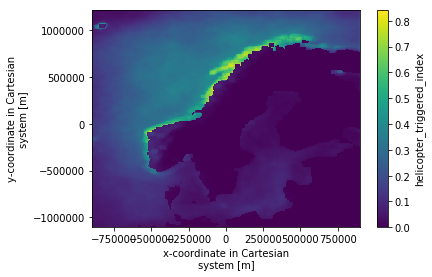

In [99]:
y1.plot()

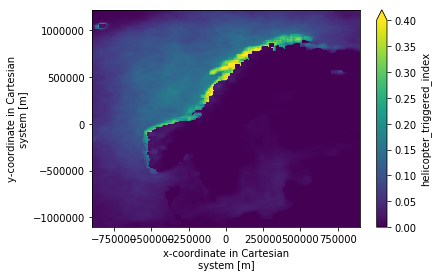

In [106]:
b0.plot(vmax=.4)

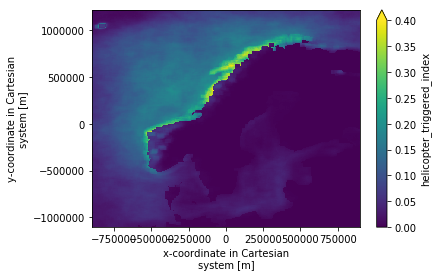

In [107]:
b1.plot(vmax=.4)

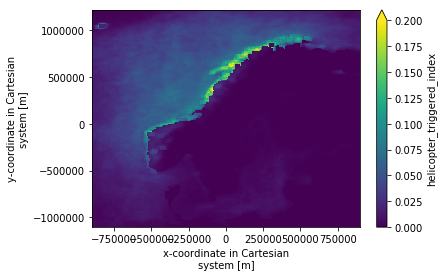

In [109]:
r0.plot(vmax=0.2)

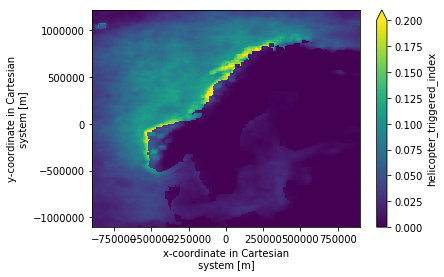

In [112]:
r1.plot(vmax=.2)

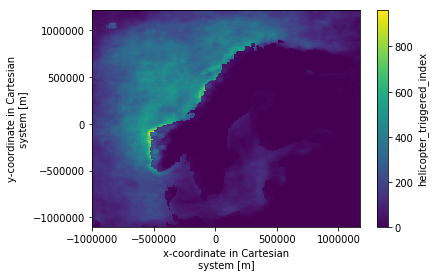

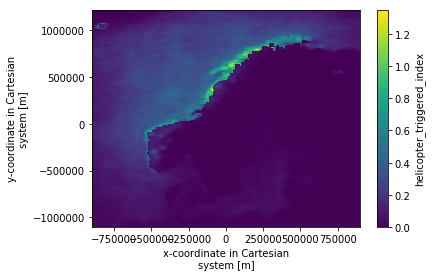

In [86]:
red.plot()

In [23]:
yellow,brown,red = original

In [35]:
xarray = xr.open_dataset("source_disk/MEPS/extracted_variables/extracted_20180901T00Z.nc").isel(ensemble_member=0,height0 = 0)
xarray["upward_air_velocity_pl"].time

<xarray.DataArray 'time' (time: 7)>
array(['2018-09-01T03:00:00.000000000', '2018-09-01T04:00:00.000000000',
       '2018-09-01T05:00:00.000000000', '2018-09-01T06:00:00.000000000',
       '2018-09-01T07:00:00.000000000', '2018-09-01T08:00:00.000000000',
       '2018-09-01T09:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time             (time) datetime64[ns] 2018-09-01T03:00:00 ... 2018-09-01T09:00:00
    ensemble_member  int16 0
    height0          float32 0.0
Attributes:
    long_name:      time
    standard_name:  time

In [47]:
test = (xarray["precipitation_amount_acc"]- xarray["precipitation_amount_acc"].shift({"time":1},fill_value=0)).isel(time = range(1,7))
test

<xarray.DataArray 'precipitation_amount_acc' (time: 6, y: 949, x: 889)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * time             (time) datetime64[ns] 2018-09-01T04:00:00 ... 2018-09-01T09:00:00
    ensemble_member  int16 0
    height0          float32 0.0
  * x                (x) float32 -1022485.4 -1019985.4 ... 1195014.6 1197514.6
  * y                (y) float32 -1129330.6 -1126830.6 ... 1238169.4 1240669.4
    longitude        (y, x) float64 0.238 0.2728 0.3077 ... 49.5 49.56 49.61
    latitude         (y, x) float64 51.85 51.85 51.86 ... 71.18 71.17 71.16

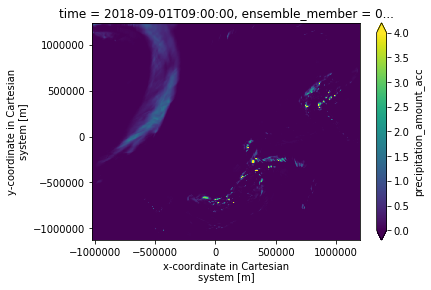

In [51]:
test.isel(time=5).plot(vmin=0,vmax=4)

In [108]:
ds = xr.open_dataset("source_disk/results/HTI_climatology_MEPS")
yellow = ds["yellow"]
brown  = ds["brown"]
red    = ds["red"]
ds.attrs["about"] = "Percentage of forecasted above tresholds (see threholds attribute)"


In [109]:
ds.dims["x"]


719

Text(0.5,1,'Percentage of reported yellow')

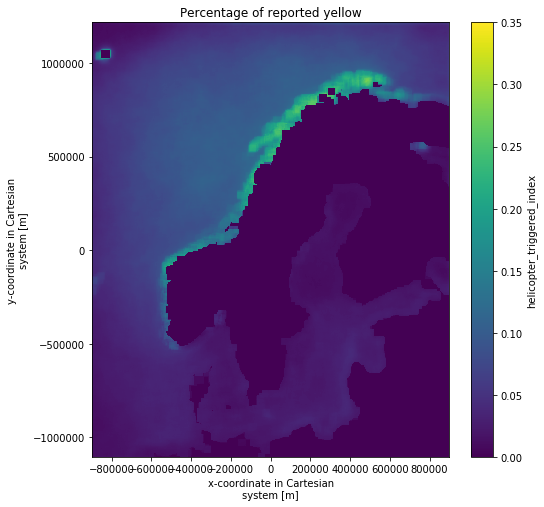

In [24]:
fig,ax = plt.subplots(figsize=(8,8))
yellow.plot(ax=ax,vmin=0.0,vmax=.35)
ax.set_title("Percentage of reported yellow")


Text(0.5,1,'Percentage of reported brown')

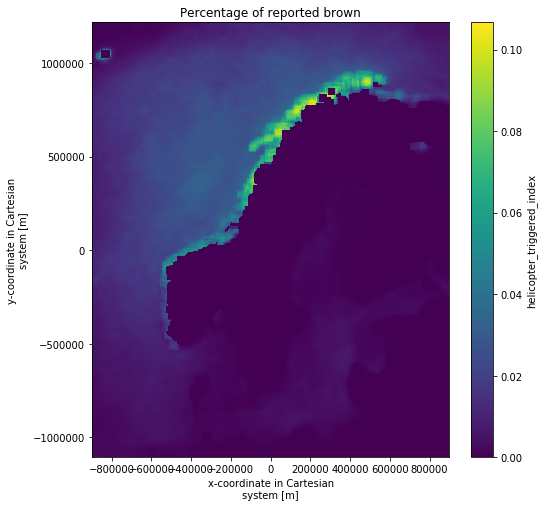

In [25]:
fig,ax = plt.subplots(figsize=(8,8))
brown.plot(ax=ax,vmin=0.0)
ax.set_title("Percentage of reported brown")


Text(0.5,1,'Percentage of reported red')

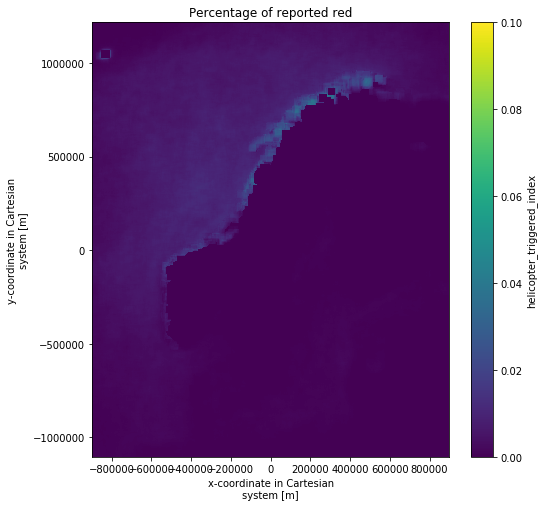

In [26]:
fig,ax = plt.subplots(figsize=(8,8))
red.plot(ax=ax,vmin=0.0,vmax=.10)
ax.set_title("Percentage of reported red")


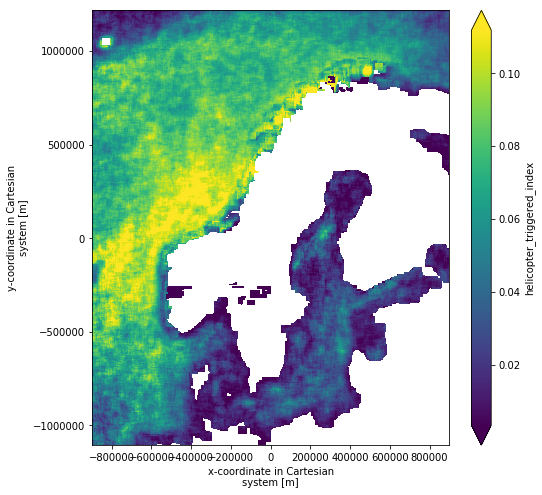

In [19]:
plt.figure(figsize=(8,8))

(red/yellow).plot(robust=1)

In [17]:
ds = xr.merge([yellow.rename("yellow"),brown.rename("brown"),red.rename("red")])/(k*20)

In [19]:
ds.to_netcdf("source_disk/results/HTI_climatology_MEPS")